dataset dari dosen

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score


In [83]:
file_path = r"C:\Users\HP\Documents\data mining\dataset\produksiPadi.xlsx"
data = pd.read_excel(file_path)

data.head()

,Tahun,Produksi Padi(Ton)
0,1970,18693649.0
1,1971,20483687.0
2,1972,19393933.0
3,1973,21490578.0
4,1974,22476073.0


In [ ]:
# Drop 'Tahun' dari dataset
data = data.drop(columns=['Tahun'])


In [85]:
# Tambahkan fitur perubahan tahunan
data['Produksi_delta'] = data['Produksi Padi(Ton)'].diff()


In [ ]:
# lagging features
num_lags = 11
for i in range(1, num_lags + 1):
    data[f'Produksi_lag{i}'] = data['Produksi Padi(Ton)'].shift(i)

# drop missing values setelah pembuatan lagging
data_lagged = data.dropna().reset_index(drop=True)

In [ ]:
# Feature target target split
X = data_lagged[[f'Produksi_lag{i}' for i in range(1, num_lags + 1)] + ['Produksi_delta']]
y = data_lagged['Produksi Padi(Ton)']


In [88]:
# Normalisasi data menggunakan Min-Max Scaler
scaler = MinMaxScaler()
X_normalized = scaler.fit_transform(X)


In [89]:
# Membagi dataset menjadi data latih (70%) dan data uji (30%)
X_train, X_test, y_train, y_test = train_test_split(X_normalized, y, test_size=0.3, random_state=42, shuffle=False)


In [90]:
# Inisialisasi model regresi linear
model = LinearRegression()

# Melatih model pada data latih
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
# Membuat prediksi pada data uji
y_pred = model.predict(X_test)

# Evaluasi model: MSE, RMSE, MAPE, r2
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mape = mean_absolute_percentage_error(y_test, y_pred)

r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}, RMSE: {rmse}, MAPE: {mape}, R-squared: {r2}")



MSE: 3.928481471750554e-16, RMSE: 1.9820397250687367e-08, MAPE: 2.437831185189545e-16, R-squared: 1.0


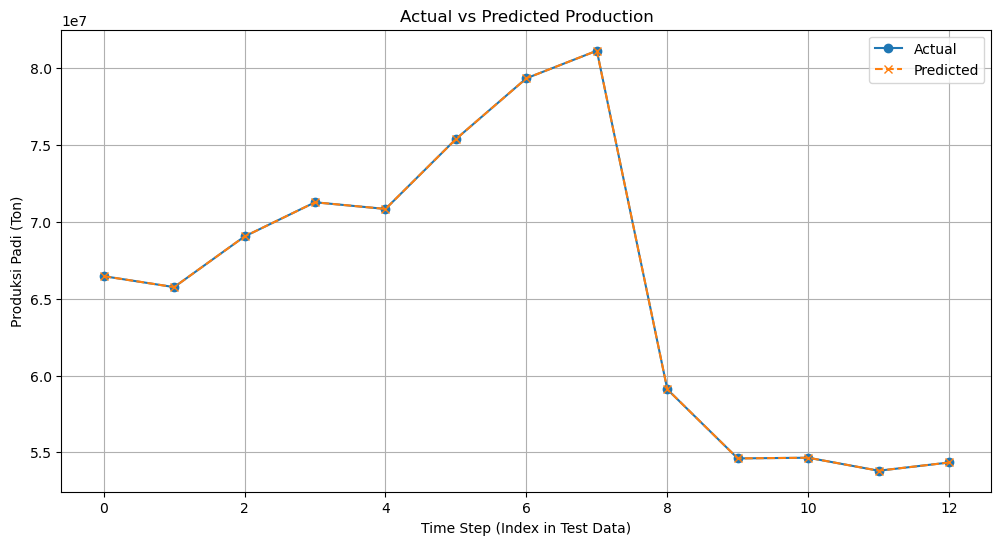

In [92]:
# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", marker='o', linestyle='-')
plt.plot(y_pred, label="Predicted", marker='x', linestyle='--')
plt.title("Actual vs Predicted Production")
plt.xlabel("Time Step (Index in Test Data)")
plt.ylabel("Produksi Padi (Ton)")
plt.legend()
plt.grid(True)
plt.show()


hyperparameter tuning : ridge regression dengan gridsearchcv

Best Alpha: 0.001
Ridge Regression - MSE: 416343820107.2891, R-squared: 0.9952845967500664


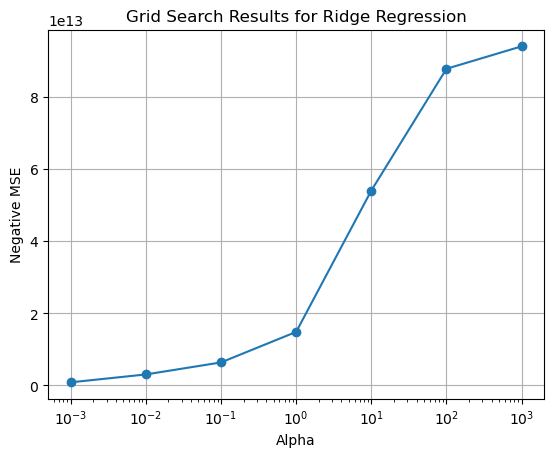

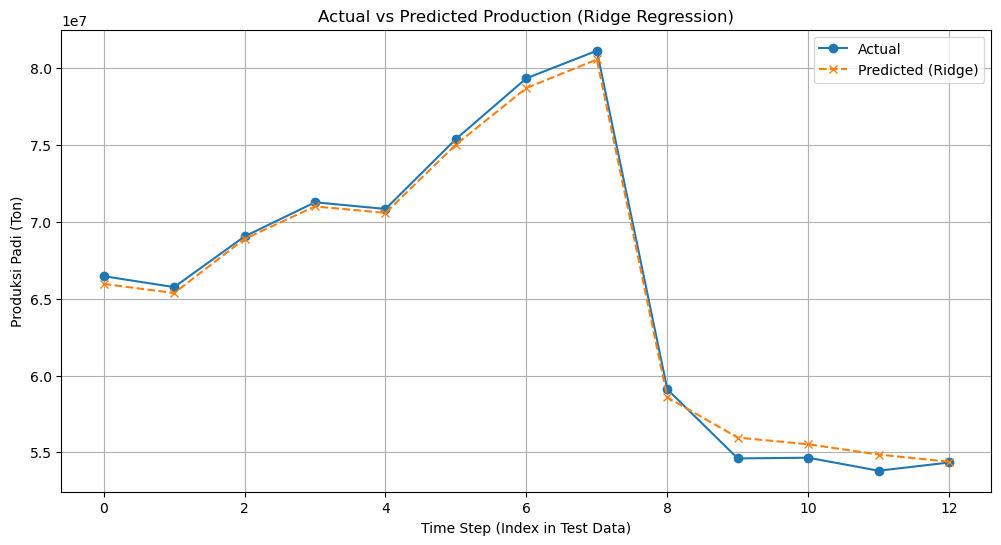

In [ ]:
# hyperparameter tuning : ridge regression dengan gridsearchcv
# hasil tuning menunjukkan nilai aplha terbaik = 0.01, yg 
# menunjukkan sedikit regularisasi sdh cukup. 
# R-regression membantu dlm kasus multikolinearitas antara fitur, yg sering muncul pd data lagging

ridge = Ridge()
param_grid = {'alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
grid_search = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error',  cv=TimeSeriesSplit(n_splits=5))
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
y_pred_ridge = best_model.predict(X_test)
best_alpha = grid_search.best_params_['alpha']
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Best Alpha: {best_alpha}")
print(f"Ridge Regression - MSE: {mse_ridge}, R-squared: {r2_ridge}")

# Plot hasil GridSearch
results = pd.DataFrame(grid_search.cv_results_)
plt.plot(results['param_alpha'], -results['mean_test_score'], marker='o')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Negative MSE')
plt.title('Grid Search Results for Ridge Regression')
plt.grid()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual", marker='o', linestyle='-')
plt.plot(y_pred_ridge, label="Predicted (Ridge)", marker='x', linestyle='--')
plt.title("Actual vs Predicted Production (Ridge Regression)")
plt.xlabel("Time Step (Index in Test Data)")
plt.ylabel("Produksi Padi (Ton)")
plt.legend()
plt.grid(True)
plt.show()


evaluation metrics : r-squared 

In [ ]:
# evaluation metrics : r-squared 
# mengindikasikan model dpt menjelaskan 95.95% variabilitas data target. menunjukkan model cukup kuat
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")




R-squared: 1.0


feature selection : seleksi fitur dengan korelasi

In [ ]:
# Korelasi matriks terhadap target
correlation = data_lagged.corr()['Produksi Padi(Ton)'].sort_values(ascending=False)
print(correlation)

# Pilih fitur dengan korelasi > |0.5|
selected_features = correlation[abs(correlation) > 0.5].index.tolist()
selected_features.remove('Produksi Padi(Ton)')  # Hapus target dari daftar
print("Selected Features:", selected_features)

# Matriks korelasi tanpa 'Tahun'
correlation = data_lagged.corr()['Produksi Padi(Ton)'].sort_values(ascending=False)
print("Correlation with Target:")
print(correlation)



Produksi Padi(Ton)    1.000000
Produksi_lag1         0.946505
Produksi_lag2         0.880838
Produksi_lag3         0.833555
Produksi_lag4         0.795248
Produksi_lag7         0.769842
Produksi_lag11        0.767177
Produksi_lag8         0.766003
Produksi_lag6         0.760629
Produksi_lag5         0.757448
Produksi_lag10        0.755993
Produksi_lag9         0.754267
Produksi_delta        0.031523
Name: Produksi Padi(Ton), dtype: float64
Selected Features: ['Produksi_lag1', 'Produksi_lag2', 'Produksi_lag3', 'Produksi_lag4', 'Produksi_lag7', 'Produksi_lag11', 'Produksi_lag8', 'Produksi_lag6', 'Produksi_lag5', 'Produksi_lag10', 'Produksi_lag9']
Correlation with Target:
Produksi Padi(Ton)    1.000000
Produksi_lag1         0.946505
Produksi_lag2         0.880838
Produksi_lag3         0.833555
Produksi_lag4         0.795248
Produksi_lag7         0.769842
Produksi_lag11        0.767177
Produksi_lag8         0.766003
Produksi_lag6         0.760629
Produksi_lag5         0.757448
Produksi_lag

In [96]:

# Inisialisasi model
model = LinearRegression()
rfe = RFE(model, n_features_to_select=5)  # Pilih 5 fitur terbaik
rfe.fit(X, y)

# Pilih fitur terbaik
selected_features = X.columns[rfe.support_]
print("Selected Features:", selected_features)


# Hitung VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)



Selected Features: Index(['Produksi_lag1', 'Produksi_lag8', 'Produksi_lag9', 'Produksi_lag11',
       'Produksi_delta'],
      dtype='object')
           feature          VIF
0    Produksi_lag1   233.085120
1    Produksi_lag2   579.818968
2    Produksi_lag3   565.432019
3    Produksi_lag4   547.139831
4    Produksi_lag5  1698.119916
5    Produksi_lag6  3096.837006
6    Produksi_lag7  3210.399367
7    Produksi_lag8  3600.583478
8    Produksi_lag9  3081.948872
9   Produksi_lag10  2747.441809
10  Produksi_lag11  1361.521182
11  Produksi_delta     1.342054


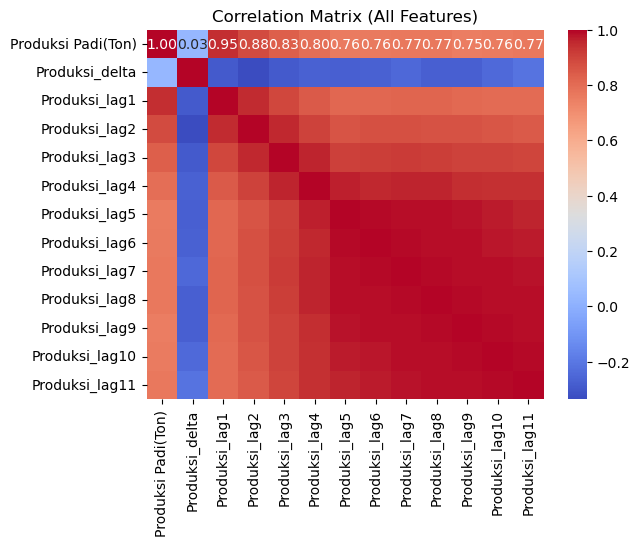

In [ ]:
# heatmap korelasi matriks
sns.heatmap(data_lagged.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Matrix (All Features)")
plt.show()


In [107]:
# Validasi model menggunakan RFE
model = LinearRegression()
scores = cross_val_score(model, X[selected_features], y, cv=5, scoring='neg_mean_squared_error')
print("MSE with selected features:", -scores.mean())


MSE with selected features: 4.209595635037052e-17


In [104]:
from sklearn.linear_model import LassoCV

lasso = LassoCV(cv=5, random_state=42)
lasso.fit(X, y)

# Fitur dengan koefisien != 0
selected_features = X.columns[lasso.coef_ != 0]
print("Selected Features:", selected_features)


Selected Features: Index(['Produksi_lag1', 'Produksi_lag11', 'Produksi_delta'], dtype='object')


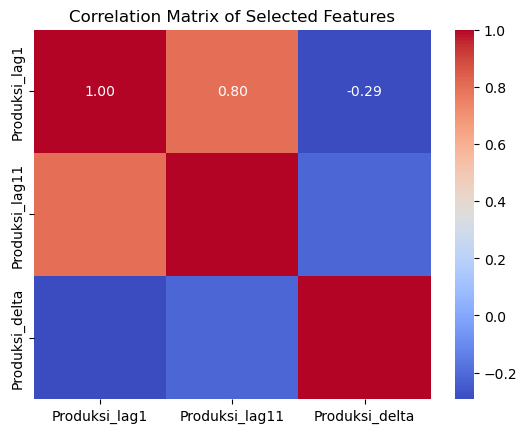

In [106]:
# Matriks korelasi fitur terpilih
selected_corr = data_lagged[selected_features].corr()
sns.heatmap(selected_corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title("Correlation Matrix of Selected Features")
plt.show()


In [ ]:
# validasi dengan cross validation score
# Mengukur kinerja model dengan validasi silang menggunakan fitur yang dipilih.
tscv = TimeSeriesSplit(n_splits=5)
scores = cross_val_score(model, X_normalized, y, cv=tscv, scoring='neg_mean_squared_error')
print("Average MSE:", -scores.mean())


Average MSE: 650010400745.4092
